In [856]:
import tensorflow as tf
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
sb.set()

# Keras imports
import keras
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense,Conv2D, Dropout, Flatten, MaxPooling2D, Activation, LeakyReLU
from keras.optimizers import RMSprop, Adam, sgd

In [857]:
# starting work on mnist branch.splitting the data into train/test. x = images, y = class 0-9;
mnist = keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

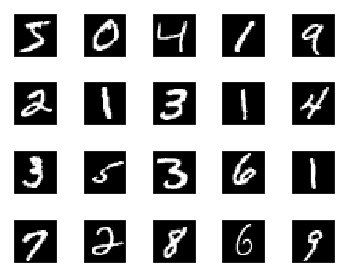

mnist shape
(60000, 28, 28)
mnist shape: first dim
60000
mnist shape: second dim
28


In [858]:
# display a sample of the mnist data
plt.figure(figsize=(5, 4))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(x_train[i], cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

print('mnist shape')
print(x_train.shape)
print('mnist shape: first dim')
print(x_train.shape[0])
print('mnist shape: second dim')
print(x_train.shape[1])

In [863]:
# Input noise to generator, -1 to 1 b/c of tanh
def sample_Z(num_of_samples, sample_size):
    return np.random.normal(loc=0, scale=1, size=(num_of_samples, sample_size))

In [864]:
# Generator function - take in one sample of random data
def generator(Z, reuse=False):
    # create a sequential model
    model = Sequential()
    
    # layers
    model.add(Dense(128, input_shape = (100,)))
    model.add(keras.layers.LeakyReLU(alpha=0.01))
    model.add(Dense(784))
    model.add(Activation('tanh'))
    
    # model name
    model.name='generator'
    
    # print the structure of the model
    print(model.summary())
    
    # output of the model
    return model

In [865]:
# discriminator - takes in an image, outputs probability that it is real or fake
def discriminator(X,reuse=False):
    
    # create a sequential model
    model = Sequential()
    
    # layers
    model.add(Dense(128, input_shape = (784,)))
    model.add(keras.layers.LeakyReLU(alpha=0.01))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    # model name 
    model.name='discriminator'
    
    # print the structure of the model
    print(model.summary())
    
    # output of the model
    return model
    

In [866]:
# making a model's layers trainable
def make_trainable(model):
    for layer in model.layers:
        layer.trainable = True


# making a model non-trainable by keeping its weights constant
def make_non_trainable(model):
    for layer in model.layers:
        layer.trainable = False


In [867]:
# preprocessing function for the mnist data 
def preprocess(x):
    x = x.reshape(-1,784)
    x = np.float64(x)
    x = (x / 255 - 0.5) * 2
    x = np.clip(x, -1, 1)
    return x

In [868]:
# deprocessing function for viewing images
def deprocess(x):
    x = (x / 2 + 1) * 255
    x = np.clip(x, 0, 255)
    x = np.uint8(x)
    x = x.reshape(28, 28)
    return x

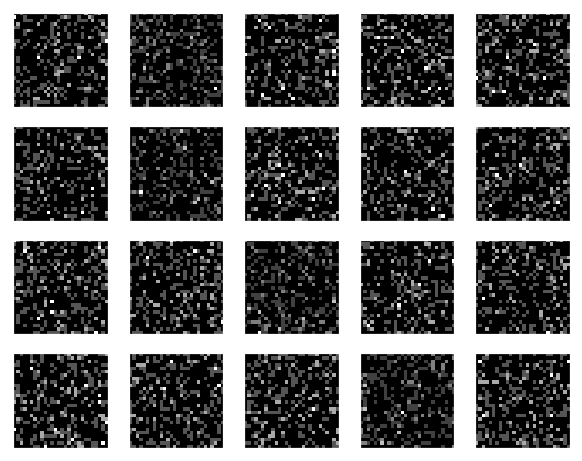

In [869]:
# deprocessing output test
deprocess_test = sample_Z(20,784)
deprocess_test = preprocess(deprocess_test)
plt.figure(figsize=(10,8))
for i in range(20):
    img = deprocess(deprocess_test[i])
    plt.subplot(4, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.show()

In [870]:
# creating labels for the data
def make_labels(rows):
    #return np.ones([size, 1]), np.zeros([size, 1])
    return np.random.uniform(low=0.0, high=0.1, size=(rows,1)), np.random.uniform(low=0.9, high=1.0, size=(rows,1))
b = make_labels(10)
print(b)

(array([[0.08443351],
       [0.06971783],
       [0.09145291],
       [0.06310082],
       [0.09844601],
       [0.0278071 ],
       [0.02009078],
       [0.0870085 ],
       [0.09778486],
       [0.09633542]]), array([[0.99796015],
       [0.93499201],
       [0.96775486],
       [0.99100966],
       [0.98605469],
       [0.9508231 ],
       [0.94464669],
       [0.93016087],
       [0.94771962],
       [0.9554371 ]]))


In [871]:
# clear backend
K.clear_session()

# placeholder variables
Z_placeholder = K.placeholder(shape=(None,100))
X_placeholder = K.placeholder(shape=(784,))

# declaring generator and discriminator
G_sample = generator(Z_placeholder)
D_sample = discriminator(X_placeholder)

# creating gan model with shared weights
gan = Sequential([
    G_sample,
    D_sample
])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               12928     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 784)               101136    
_________________________________________________________________
activation_1 (Activation)    (None, 784)               0         
Total params: 114,064
Trainable params: 114,064
Non-trainable params: 0
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               100480    
_________________________________________________________________

In [872]:
# hyper parameters
batch_size = 64
eval_size = 16
epochs = 100
gen_learning_rate = 0.0001
d_learning_rate = 0.001

# compiling the model
D_sample.compile(optimizer=sgd(lr=d_learning_rate), loss='binary_crossentropy')
gan.compile(optimizer=Adam(lr=g_learning_rate), loss='binary_crossentropy')


# variables for data
x_train_processed = preprocess(x_train)
x_test_processed = preprocess(x_test)

y_train_real, y_train_fake = make_labels(batch_size)
y_eval_real,  y_eval_fake  = make_labels(eval_size)


losses = []

# training for-loop
for e in range(epochs):
    for i in range(len(x_train_processed)//batch_size):
        # the real mnist images
        x_batch_real = x_train_processed[i * batch_size: (i+1)*batch_size]
        
        # noise samples and corresponding images created by generator
        noise_samples = sample_Z(batch_size, 100)
        x_batch_fake = G_sample.predict_on_batch(noise_samples)
        
        # training the discriminator to detect real and fake images
        make_trainable(D_sample)
        D_sample.train_on_batch(x_batch_real, y_train_real)
        D_sample.train_on_batch(x_batch_fake, y_train_fake)
        
        # training the generator (using the combined gan model)
        make_non_trainable(D_sample)
        gan.train_on_batch(noise_samples, y_train_real)
        
    # evaluate
    x_eval_real = x_train_processed[np.random.choice(len(x_train_processed), eval_size, replace=False)]
    
    noise_samples = sample_Z(eval_size, 100)
    x_eval_fake = G_sample.predict_on_batch(noise_samples)
        
    d_loss = D_sample.test_on_batch(x_eval_real, y_eval_real)
    d_loss += D_sample.test_on_batch(x_eval_fake, y_eval_fake)
    g_loss = gan.test_on_batch(noise_samples, y_eval_real) # want fakes to be realistic
    
    losses.append((d_loss, g_loss))
    
    print("Epoch: {:>3}/{} Discriminator Loss: {:>6.4f} Generator Loss: {:>6.4f}".format(
        e+1, epochs, d_loss, g_loss))

Epoch:   1/100 Discriminator Loss: 2.5166 Generator Loss: 0.1886
Epoch:   2/100 Discriminator Loss: 1.9180 Generator Loss: 0.5611
Epoch:   3/100 Discriminator Loss: 1.2736 Generator Loss: 0.4097
Epoch:   4/100 Discriminator Loss: 1.0074 Generator Loss: 1.3035
Epoch:   5/100 Discriminator Loss: 0.4448 Generator Loss: 1.6136
Epoch:   6/100 Discriminator Loss: 0.6717 Generator Loss: 0.9420
Epoch:   7/100 Discriminator Loss: 1.2315 Generator Loss: 0.6762
Epoch:   8/100 Discriminator Loss: 0.6674 Generator Loss: 0.9604
Epoch:   9/100 Discriminator Loss: 0.6452 Generator Loss: 1.3137
Epoch:  10/100 Discriminator Loss: 0.6781 Generator Loss: 0.9632
Epoch:  11/100 Discriminator Loss: 0.5723 Generator Loss: 1.1465
Epoch:  12/100 Discriminator Loss: 0.5603 Generator Loss: 1.1543
Epoch:  13/100 Discriminator Loss: 0.6061 Generator Loss: 1.6092
Epoch:  14/100 Discriminator Loss: 1.0907 Generator Loss: 0.5188
Epoch:  15/100 Discriminator Loss: 0.5274 Generator Loss: 1.2757
Epoch:  16/100 Discrimina

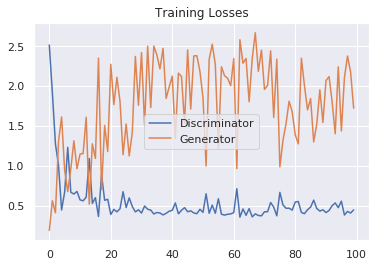

In [873]:
losses = np.array(losses)

fig, ax = plt.subplots()
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()
plt.show()

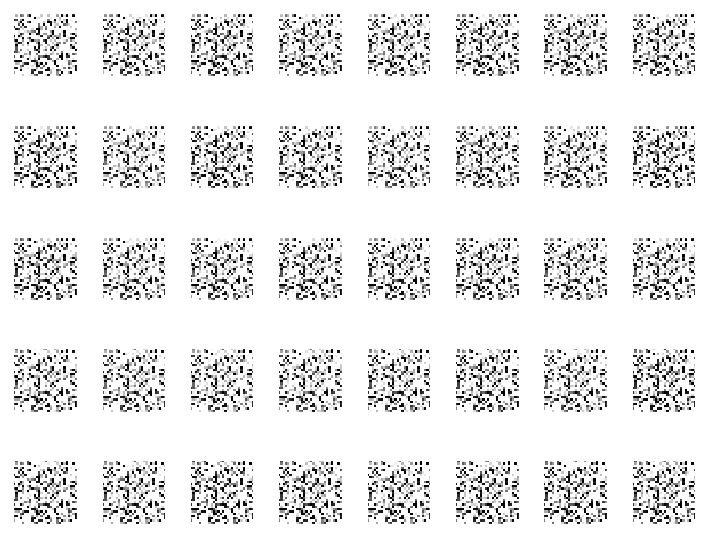

In [874]:
post_training_test = sample_Z(40,100)
generated_digits = G_sample.predict(post_training_test)

plt.figure(figsize=(10, 8))
for i in range(40):
    img = deprocess(generated_digits[i])
    plt.subplot(5, 8, i+1)
    plt.imshow(img, cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()
#plt.savefig('2nd_gen.png')

In [ ]:
# Needs adaptation

# r_logits, r_rep = D_sample(X)
# f_logits, g_rep = D_Sample(G_sample,reuse=True)

# disc_loss = tef.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=r_logits,labels=tf.ones_like(r_logits)) + tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits,labels=tf.zeros_like(f_logits)))
# gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits,labels=tf.ones_like(f_logits)))

In [ ]:
# gen_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="GAN/Generator")
# disc_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="GAN/Discriminator")

# gen_step = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(gen_loss,var_list = gen_vars) # G Train step
# disc_step = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(disc_loss,var_list = disc_vars) # D Train step

# sess = tf.Session(config=config)
# sess = tf.Session()
# tf.global_variables_initializer().run(session=sess)

# batch_size = 256
# nd_steps = 10
# ng_steps = 10

# x_plot = sample_data(n=batch_size)

# f = open('loss_logs.csv','w')
# f.write('Iteration,Discriminator Loss,Generator Loss\n')

In [246]:
# for i in range(10001):
#     X_batch = sample_data(n=batch_size)
    
#     # 28 x 28 pixel images
#     Z_batch = sample_Z(batch_size, 28, 28)

#     for _ in range(nd_steps):
#         _, dloss = sess.run([disc_step, disc_loss], feed_dict={X: X_batch, Z: Z_batch})
#     rrep_dstep, grep_dstep = sess.run([r_rep, g_rep], feed_dict={X: X_batch, Z: Z_batch})

#     for _ in range(ng_steps):
#         _, gloss = sess.run([gen_step, gen_loss], feed_dict={Z: Z_batch})

#     rrep_gstep, grep_gstep = sess.run([r_rep, g_rep], feed_dict={X: X_batch, Z: Z_batch})

#     print("Iterations: %d\t Discriminator loss: %.4f\t Generator loss: %.4f" % (i,dloss,gloss))
#     if i%10 == 0:
#         f.write("%d,%f,%f\n"%(i,dloss,gloss))

#     if i%1000 == 0:
#         # Iterations gif
#         plt.figure()
#         g_plot = sess.run(G_sample, feed_dict={Z: Z_batch})
#         xax = plt.scatter(x_plot[:,0], x_plot[:,1])
#         gax = plt.scatter(g_plot[:,0],g_plot[:,1])
#         plt.xlim(-60, 60)
#         plt.ylim(-50, 2600)
#         plt.legend((xax,gax), ("Real Data","Generated Data"))
#         plt.title('Samples at Iteration %d'%i)
#         plt.tight_layout()
#         plt.savefig('../plots/iterations/iteration_%d.png'%i)
#         plt.close()

#         # Feature transform gif
#         plt.figure()
#         rrd = plt.scatter(rrep_dstep[:,0], rrep_dstep[:,1], alpha=0.5)
#         rrg = plt.scatter(rrep_gstep[:,0], rrep_gstep[:,1], alpha=0.5)
#         grd = plt.scatter(grep_dstep[:,0], grep_dstep[:,1], alpha=0.5)
#         grg = plt.scatter(grep_gstep[:,0], grep_gstep[:,1], alpha=0.5)
#         plt.xlim(-200, 200)
#         plt.ylim(-40, 40)
#         plt.legend((rrd, rrg, grd, grg), ("Real Data Before G step","Real Data After G step",
#                                "Generated Data Before G step","Generated Data After G step"))
#         plt.title('Transformed Features at Iteration %d'%i)
#         plt.tight_layout()
#         plt.savefig('../plots/features/feature_transform_%d.png'%i)
#         plt.close()

#         # Feature transform of centroids gif
#         plt.figure()
#         rrdc = plt.scatter(np.mean(rrep_dstep[:,0]), np.mean(rrep_dstep[:,1]),s=100, alpha=0.5)
#         rrgc = plt.scatter(np.mean(rrep_gstep[:,0]), np.mean(rrep_gstep[:,1]),s=100, alpha=0.5)
#         grdc = plt.scatter(np.mean(grep_dstep[:,0]), np.mean(grep_dstep[:,1]),s=100, alpha=0.5)
#         grgc = plt.scatter(np.mean(grep_gstep[:,0]), np.mean(grep_gstep[:,1]),s=100, alpha=0.5)
#         plt.xlim(-50, 50)
#         plt.ylim(-50, 50)
#         plt.legend((rrdc, rrgc, grdc, grgc), ("Real Data Before G step","Real Data After G step",
#                                "Generated Data Before G step","Generated Data After G step"))

#         plt.title('Centroid of Transformed Features at Iteration %d'%i)
#         plt.tight_layout()
#         plt.savefig('../plots/features/feature_transform_centroid_%d.png'%i)
#         plt.close()

# f.close()